# Part I: *Data Analysis and Preprocessing*

## A. Data Manipulation

#### a. Import, visualize, and save the contents of a dataset.

##### *algerian soil props*

In [1]:
import pandas as pd
import numpy as np
import io

df = pd.read_excel('../Data/soil_dz_allprops.xlsx')

# buffer = io.StringIO()
# df.info(show_counts=True, verbose=True, buf=buffer)
df.info(show_counts=True, verbose=True)
# s = buffer.getvalue()
# with open('./files/soil_dz_attributs_infos.txt', 'w') as f:
#     f.write(s)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CNT_FULLNAME      295 non-null    object 
 1   sand % topsoil    295 non-null    float64
 2   sand % subsoil    295 non-null    float64
 3   silt % topsoil    295 non-null    float64
 4   silt% subsoil     295 non-null    float64
 5   clay % topsoil    295 non-null    float64
 6   clay % subsoil    295 non-null    float64
 7   pH water topsoil  295 non-null    float64
 8   pH water subsoil  295 non-null    float64
 9   OC % topsoil      295 non-null    float64
 10  OC % subsoil      295 non-null    float64
 11  N % topsoil       295 non-null    float64
 12  N % subsoil       295 non-null    float64
 13  BS % topsoil      295 non-null    float64
 14  BS % subsoil      295 non-null    float64
 15  CEC topsoil       295 non-null    float64
 16  CEC subsoil       295 non-null    float64
 1

In [2]:
pd.set_option('display.max_columns', None)
df_no_geometry = df.drop('geometry', axis=1) 
df_no_geometry.head()

,CNT_FULLNAME,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,OC % subsoil,N % topsoil,N % subsoil,BS % topsoil,BS % subsoil,CEC topsoil,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,ALGERIA,49.57,43.09,28.200,24.200,22.230,32.710,5.86,5.39,2.4110,0.7420,0.1150,0.061,72.5,63.2,6.89,12.420,21.50,35.8,0.030,0.090,1.78,1.78,20.8,12.1
1,ALGERIA,56.97,55.06,21.440,19.190,21.690,25.680,5.92,6.02,1.0460,0.5500,0.1150,0.071,81.0,81.7,15.00,17.380,66.50,61.4,0.760,0.830,1.19,1.32,9.7,8.0
2,ALGERIA,57.39,55.21,24.315,22.825,18.295,21.965,6.27,5.75,1.2295,0.3905,0.0565,0.028,69.9,53.5,8.08,8.325,20.45,26.1,0.035,0.035,1.69,1.69,18.7,13.0
3,ALGERIA,20.41,24.08,32.930,29.190,46.620,46.690,7.86,8.03,0.6790,0.3820,0.0870,0.048,98.6,99.3,39.48,37.910,74.20,71.0,6.330,6.770,1.54,1.58,9.3,9.6
4,ALGERIA,31.42,28.46,21.650,20.520,46.890,50.950,7.32,7.49,0.6190,0.4240,0.0870,0.057,92.9,93.6,36.42,36.980,72.10,69.8,1.950,2.720,1.54,1.67,9.0,8.7


##### *wilayas' polygons data*

<class 'shapely.geometry.polygon.Polygon'>


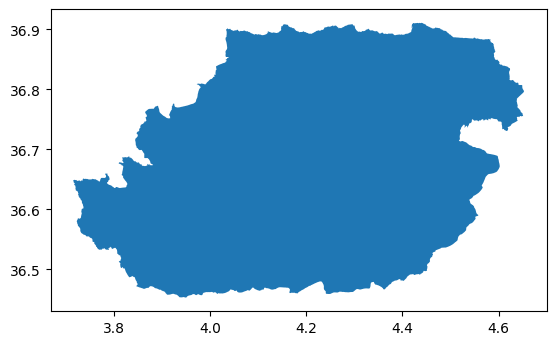

In [3]:
import geopandas as geopd

geodf = geopd.read_file(filename='../Data/wilayas/all-wilayas.shp')

geodf = geodf.drop(['name_ar', 'name_ber'], axis=1)
geodf.head(58)

tizi = geodf.loc[geodf['name'] == 'Tizi Ouzou']
tizi.head()

geo_tizi = tizi['geometry'].iloc[0]

tizi.plot()

print(type(geo_tizi))

In [4]:
geo = df['geometry']

In [5]:
geo

0      POLYGON ((5.488269805908203 36.69034957885742,...
1      POLYGON ((7.277111053466797 37.02900695800781,...
2      POLYGON ((7.367879867553711 36.955509185791016...
3      POLYGON ((7.681180000305176 36.97943878173828,...
4      POLYGON ((8.664039611816406 36.89445877075195,...
                             ...                        
290    POLYGON ((3.2276499271392822 19.95354080200195...
291    POLYGON ((5.541150093078613 19.48434066772461,...
292    POLYGON ((5.961190223693848 19.71068000793457,...
293    POLYGON ((4.107329845428467 19.135799407958984...
294    POLYGON ((4.505320072174072 19.232820510864258...
Name: geometry, Length: 295, dtype: object

In [6]:
from shapely import wkt

# Function to safely load WKT with error handling
def safe_wkt_loads(wkt_str):
    try:
        return wkt.loads(wkt_str)
    except Exception as e:
        print(f"Error parsing WKT: {wkt_str} -> {e}")
        return None  # Return None for entries that fail

# Apply safe_wkt_loads to convert WKT strings to Polygon objects
geo = geo.apply(safe_wkt_loads)

# Optionally, drop rows with None in 'geometry' if needed
geo = geo.dropna()


Error parsing WKT: POLYGON ((5.980269908905029 34.56650161743164, 5.9806599617004395 34.56270980834961, 5.991310119628906 34.5434684753418, 6.001669883728027 34.49327850341797, 5.9951300621032715 34.47127151489258, 5.9852800369262695 34.43404006958008, 5.977729797363281 34.39255905151367, 5.988339900970459 34.250099182128906, 5.987060070037842 34.188560485839844, 5.983059883117676 34.18827819824219, 5.943850040435791 34.137428283691406, 5.88778018951416 34.12255859375, 5.782830238342285 34.107120513916016, 5.748340129852295 34.08375930786133, 5.702169895172119 34.02193832397461, 5.685259819030762 33.98979187011719, 5.6882100105285645 33.96617889404297, 5.7263898849487305 33.88452911376953, 5.735680103302002 33.878028869628906, 5.75629997253418 33.804901123046875, 5.777070045471191 33.768680572509766, 5.784969806671143 33.74674987792969, 5.793479919433594 33.73598098754883, 5.8030500411987305 33.685630798339844, 5.797989845275879 33.661441802978516, 5.767859935760498 33.60118865966797, 

In [7]:
type(geo)

pandas.core.series.Series

In [8]:
results = []
for pol in geo:
    if geo_tizi.intersects(pol):
        print('Found')
        results.append(pol)

        

Found
Found
Found
Found


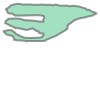

In [9]:
results[0]

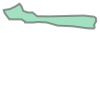

In [10]:
results[1]

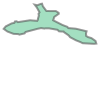

In [11]:
results[2]

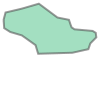

In [12]:
results[3]

C:\Users\idirb\AppData\Local\Temp\ipykernel_3596\1617259021.py:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


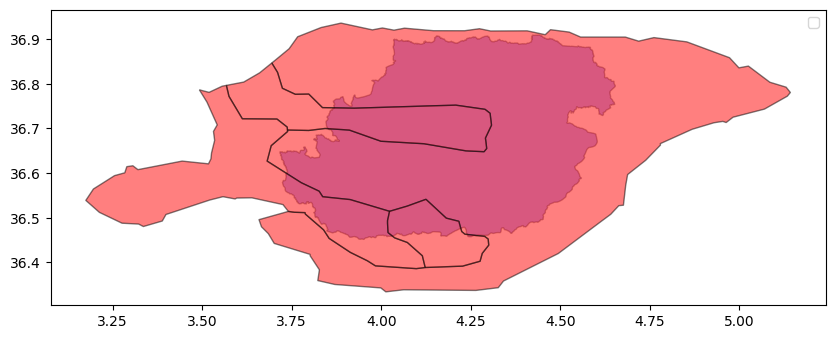

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon

#conversion de geo_tizi en GeoDataFrame
geo_tizi_gdf = gpd.GeoDataFrame(geometry=[geo_tizi], crs="EPSG:4326")

#filtrer les polygones qui intersectent geo_tizi et les convertir en GeoDataFrame
results = [pol for pol in geo if geo_tizi.intersects(pol)]
results_gdf = gpd.GeoDataFrame(geometry=results, crs="EPSG:4326")


fig, ax = plt.subplots(figsize=(10, 10))


geo_tizi_gdf.plot(ax=ax, color="blue", alpha=0.3, edgecolor="black", label="geo_tizi")


results_gdf.plot(ax=ax, color="red", edgecolor="black", alpha=0.5, label="Intersecte")


handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())


plt.show()


#### b. Provide a global description of the dataset.

#### c. Update/Delete an instance or value of the dataset.

## B. Analysis of characteristics 

#### a. Foreach attribute:

##### i. Calculate measures of central tendency and deduce symmetries

##### ii. Calculate measures of dispersion and deduce outliers

##### iii. Calculate the amount of missing values and unique values

##### iv. Construct boxplots and display outliers


##### v. Construct histograms and visualize the data distribution

#### b. Construct and display scatter plots of the data and deduce correlations

# INTERFACE

## C. Datareduction through aggregation by seasons

## D. Dataintegration: merges data from multiple sources into a single coherent dataset

## E. Multiple choices of handling outliers and missing values

## F. Datanormalization: Min-Max / z-score methods

## G. Datareduction via discretization of continuous data: Equal Frequency / Amplitude

## H. Datareduction (elimination of redundancies) horizontal / vertical